## TODO:
* when eta is high, the battery will charge and discharge more often. This leads to alot of dots in the 2nd figure. 
* run code for 2 setups with high (realistic) and low eta

In [1]:
%load_ext autoreload
%autoreload 2
from tools import EnergyStorageModel

In [2]:
import numpy as np
# how do align 

## ETA HIGH

In [74]:
# Example Usage:
model = EnergyStorageModel(eta_charge=0.98, 
                           eta_discharge=0.97, 
                           beta = 0.99,
                           a_bar = 1,
                           num_storage_levels=10,
                           num_actions=25,
                           num_price_levels=50,
                           tolerance = 1e-2,
                           max_iteration=10_000,
                           simulate_prices = True,
                           mean_reversion= 0.3,
                           p_variance = 100)

Simulating price series...


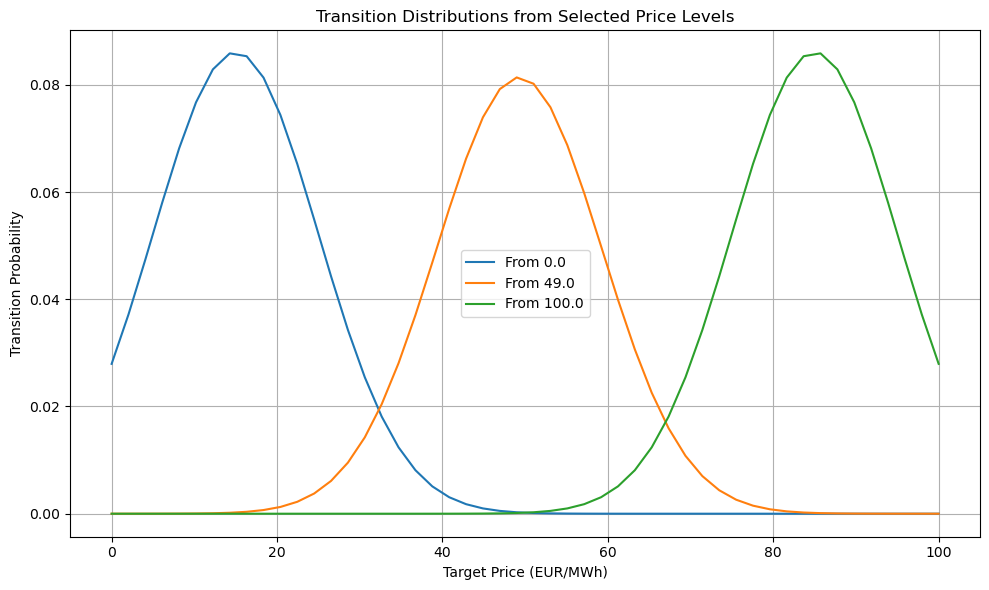

In [75]:
model.plot_price_transition_distributions()

In [76]:
V, P = model.vfi_vec() 

heyo
Converged in 626 iterations.


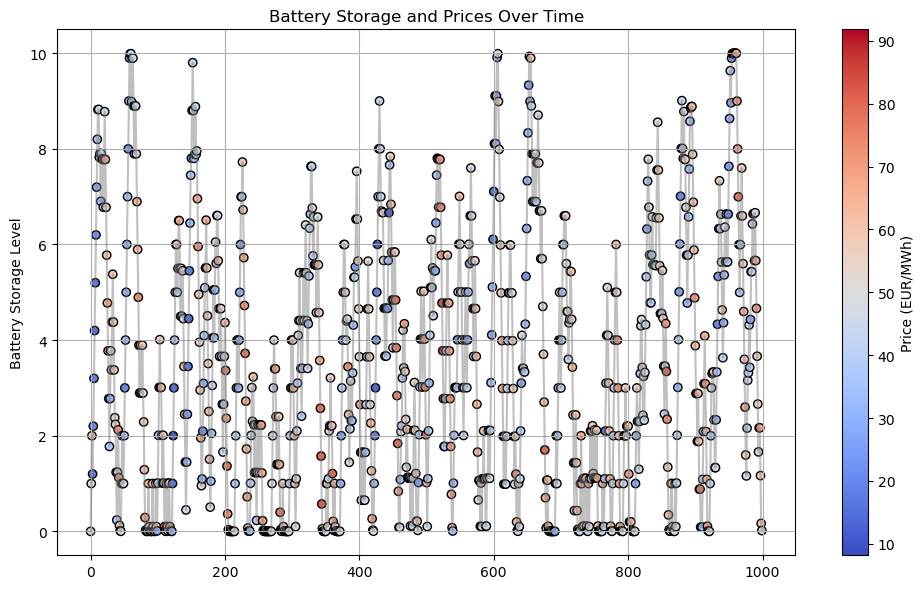

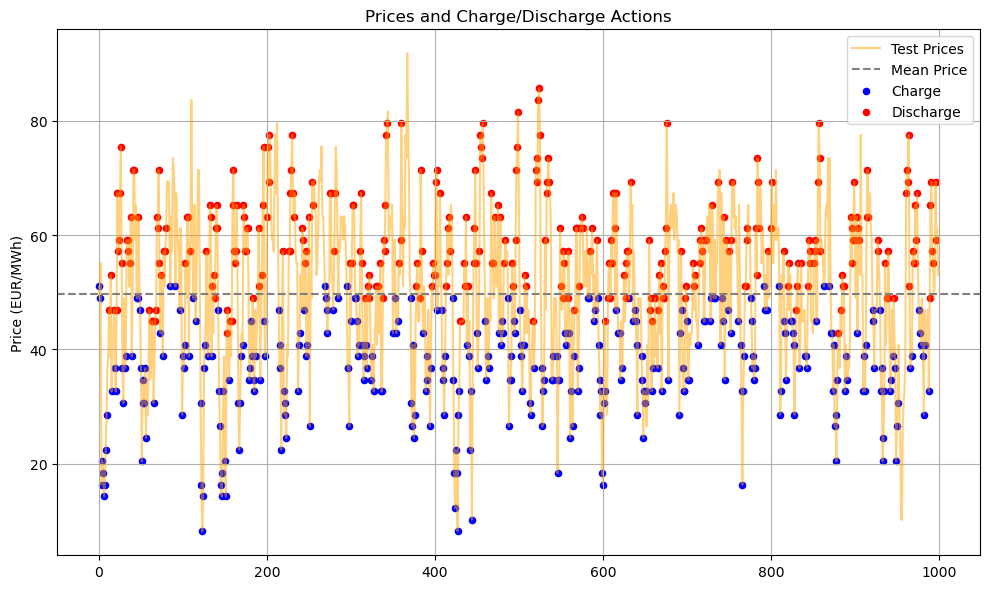

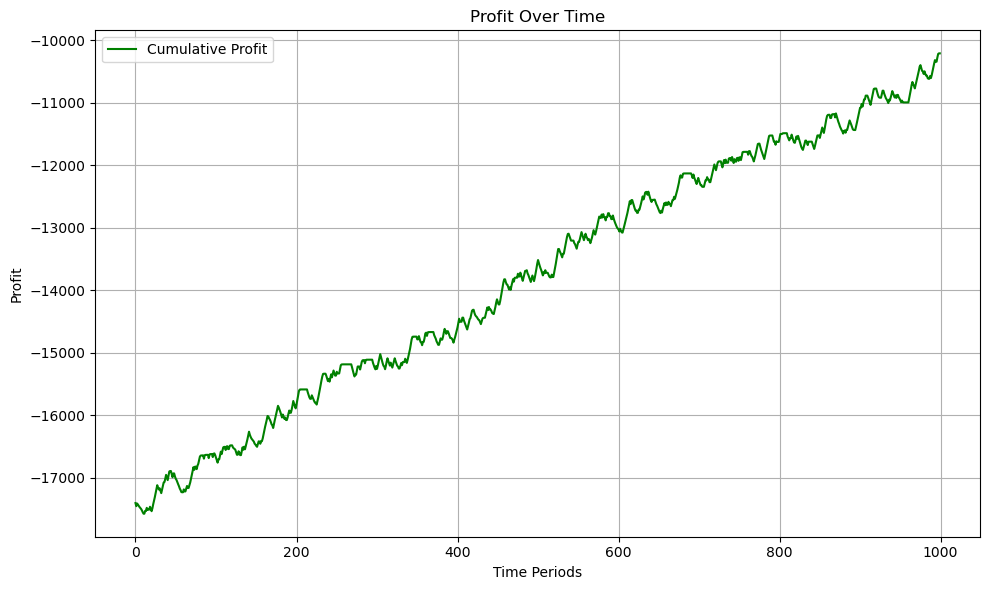

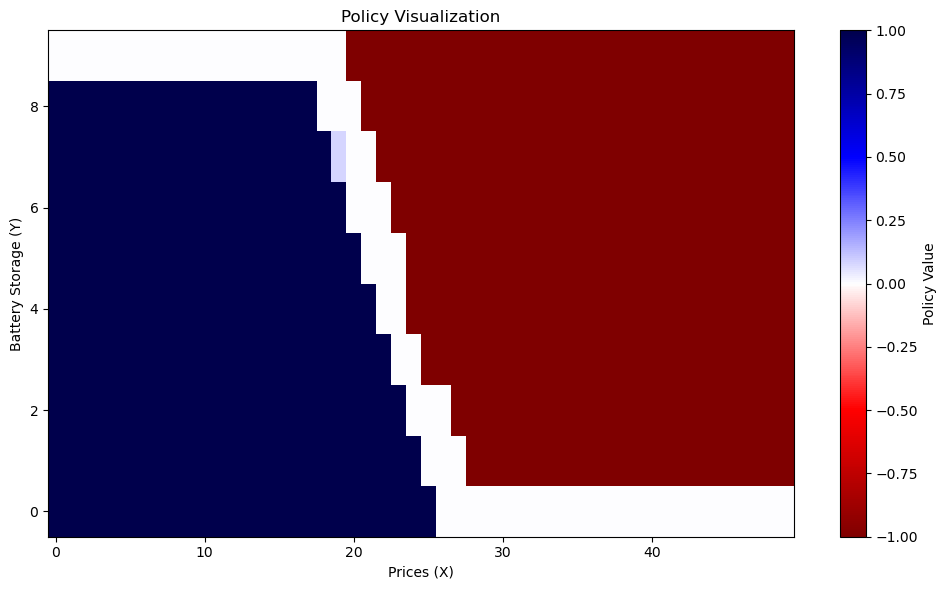

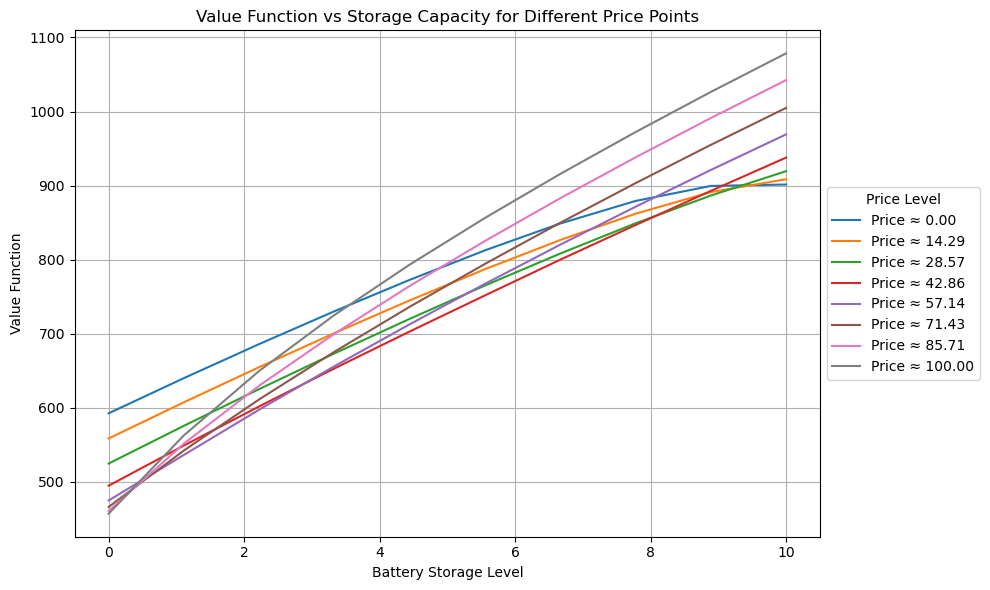

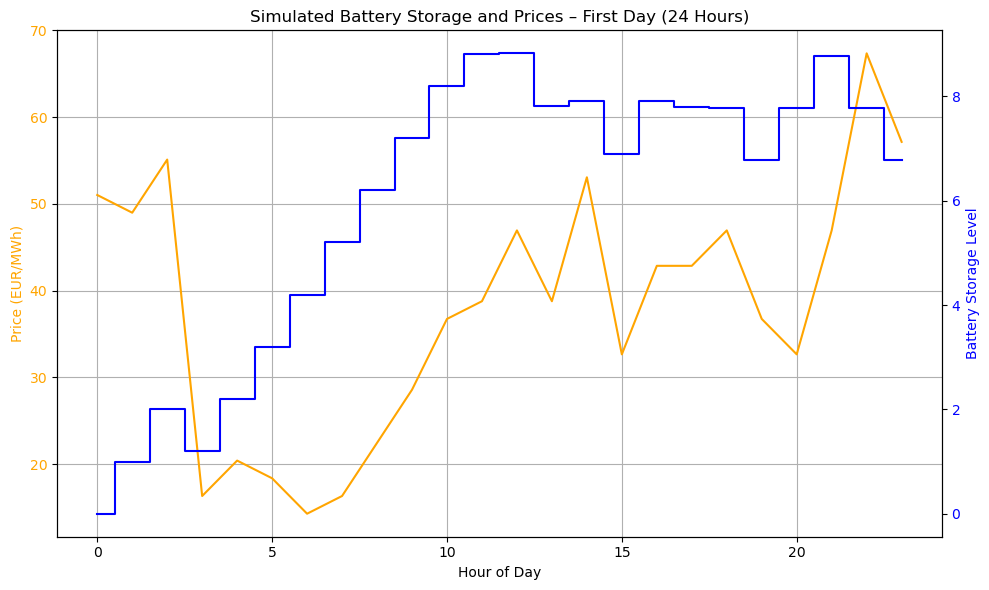

In [77]:
battery_storage_sim, profit_sim, action_sim = model.simulate(policy=P)
model.plot_results(battery_storage_sim, profit_sim, action_sim)

In [91]:
# loop over 
from collections import defaultdict

# Create a 3D dictionary (using defaultdict)
tech_policy = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))

# Initialize your parameters
N = 5
eta_chart = np.linspace(0.8, 1, N)
eta_discharge = np.linspace(0.8, 1, N)
sigma = np.linspace(0.1/100/24, 0.01, N)

# Loop over all combinations of eta_charge, eta_discharge, and sigma
for i in range(N):
    for j in range(N):
        for k in range(N):
            print(f"eta_charge: {eta_chart[i]}, eta_discharge: {eta_discharge[j]}, sigma: {sigma[k]}")
            
            # Assign values to model parameters
            model.eta_charge = eta_chart[i]
            model.eta_discharge = eta_discharge[j]
            model.sigma = sigma[k]
            
            # Call model's method to calculate policy (V, P)
            V, P = model.vfi_vec()

            battery_storage_sim, profit_sim, action_sim = model.simulate(policy=P)
            
            # Store the policy (P) in the 3D dictionary with (eta_charge, eta_discharge, sigma) as keys
            tech_policy[eta_chart[i]][eta_discharge[j]][sigma[k]] = profit_sim[-1] #


eta_charge: 0.8, eta_discharge: 0.8, sigma: 4.1666666666666665e-05
heyo
Converged in 1584 iterations.
eta_charge: 0.8, eta_discharge: 0.8, sigma: 0.00253125
heyo
Converged in 1157 iterations.
eta_charge: 0.8, eta_discharge: 0.8, sigma: 0.005020833333333333
heyo
Converged in 1155 iterations.
eta_charge: 0.8, eta_discharge: 0.8, sigma: 0.007510416666666666
heyo
Converged in 1149 iterations.
eta_charge: 0.8, eta_discharge: 0.8, sigma: 0.01
heyo
Converged in 1147 iterations.
eta_charge: 0.8, eta_discharge: 0.8500000000000001, sigma: 4.1666666666666665e-05
heyo
Converged in 1384 iterations.
eta_charge: 0.8, eta_discharge: 0.8500000000000001, sigma: 0.00253125
heyo
Converged in 1150 iterations.
eta_charge: 0.8, eta_discharge: 0.8500000000000001, sigma: 0.005020833333333333
heyo
Converged in 1147 iterations.
eta_charge: 0.8, eta_discharge: 0.8500000000000001, sigma: 0.007510416666666666
heyo
Converged in 1146 iterations.
eta_charge: 0.8, eta_discharge: 0.8500000000000001, sigma: 0.01
heyo
Con

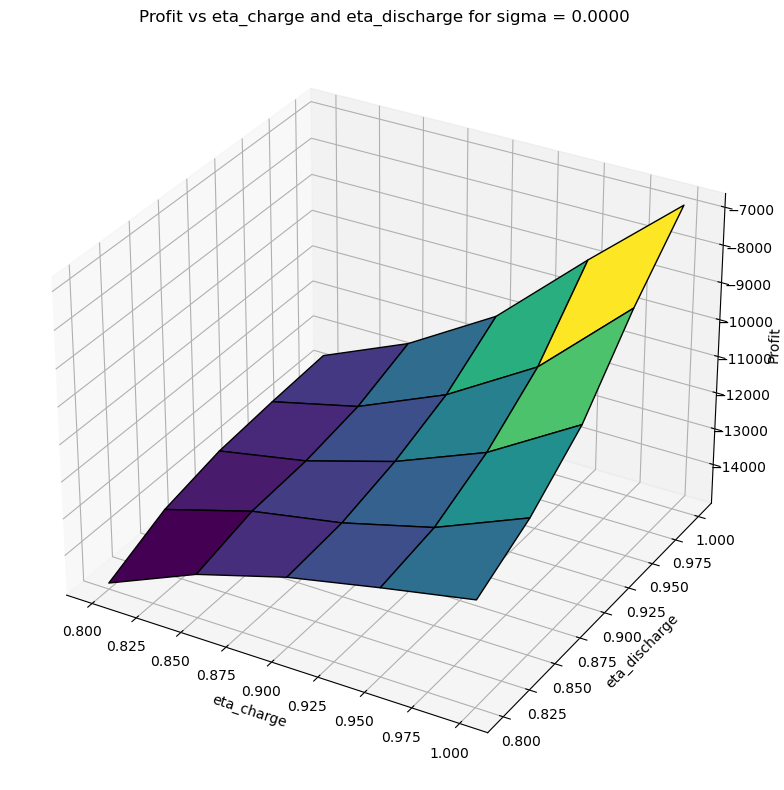

In [92]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Select a specific sigma value (e.g., 3rd sigma)
selected_sigma = sigma[0]

# Create meshgrid for eta_charge and eta_discharge
eta_grid, discharge_grid = np.meshgrid(eta_chart, eta_discharge)

# Gather profit values for the selected sigma
z_values = np.array([[tech_policy[eta_chart[i]][eta_discharge[j]][selected_sigma] 
                      for j in range(N)] for i in range(N)])

# 3D plot setup
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(eta_grid, discharge_grid, z_values, cmap='viridis', edgecolor='k')

# Labeling
ax.set_xlabel('eta_charge')
ax.set_ylabel('eta_discharge')
ax.set_zlabel('Profit')
ax.set_title(f'Profit vs eta_charge and eta_discharge for sigma = {selected_sigma:.4f}')

plt.tight_layout()
plt.show()


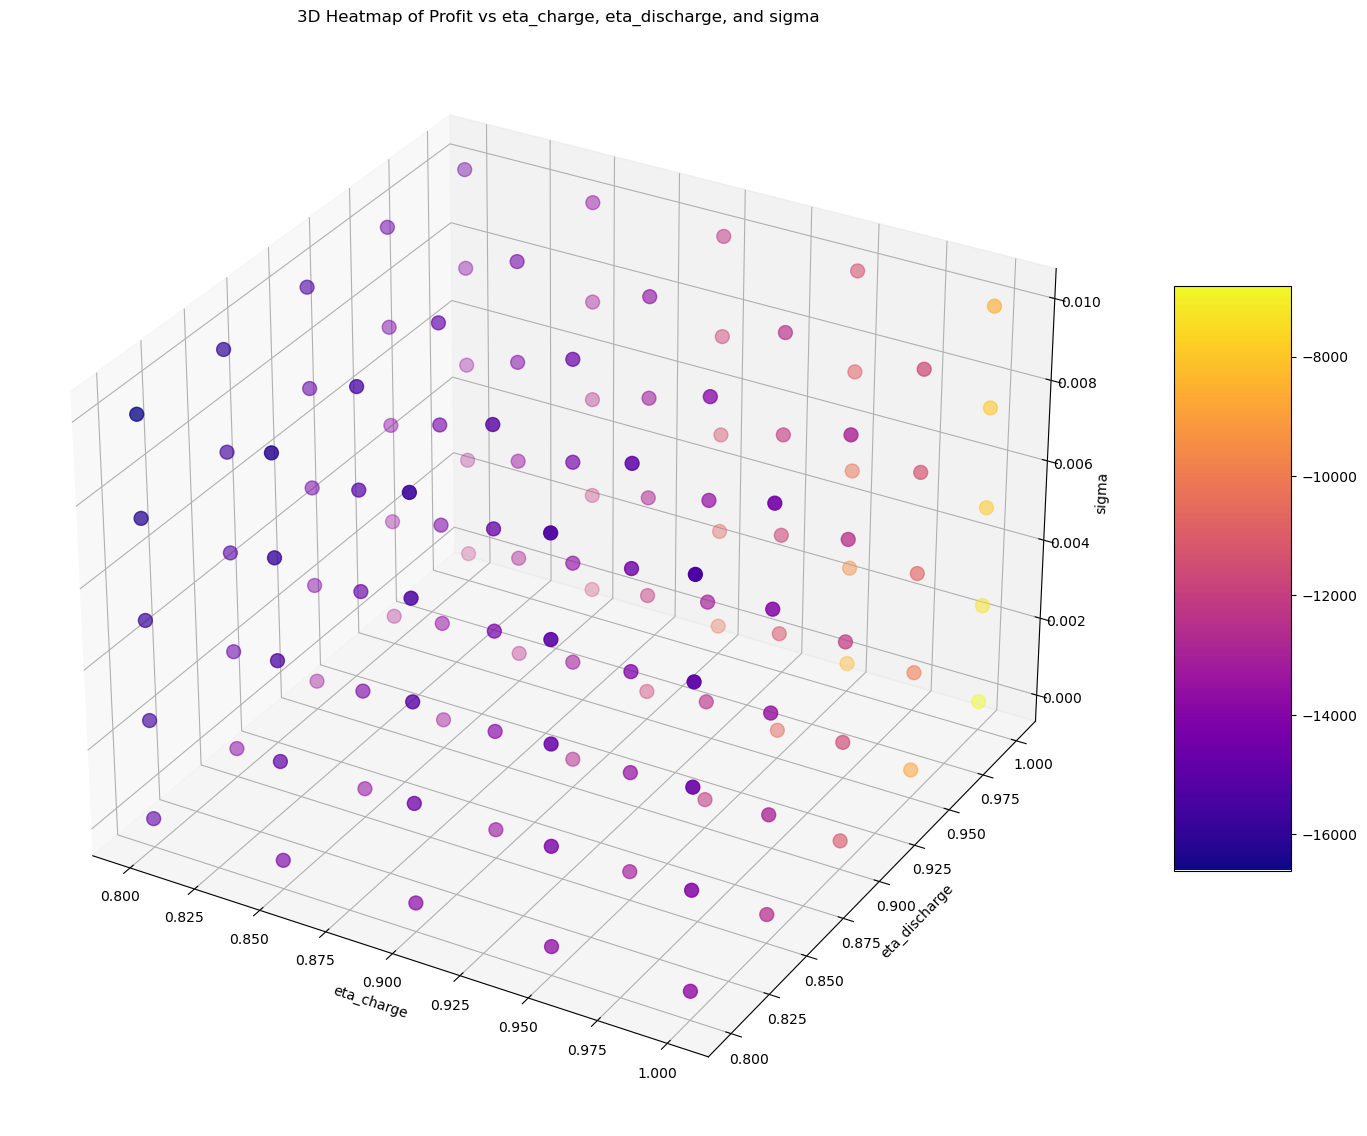

In [93]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

# Create meshgrid for eta_charge, eta_discharge, and sigma
eta_grid, discharge_grid, sigma_grid = np.meshgrid(eta_chart, eta_discharge, sigma)

# Flatten the grids for easier plotting
eta_flat = eta_grid.flatten()
discharge_flat = discharge_grid.flatten()
sigma_flat = sigma_grid.flatten()

# Gather the corresponding profit values from tech_policy
z_values = np.array([tech_policy[eta_flat[i]][discharge_flat[i]][sigma_flat[i]] 
                     for i in range(len(eta_flat))])

# 3D plot setup
fig = plt.figure(figsize=(14, 12))  # Increase figure size further for clarity
ax = fig.add_subplot(111, projection='3d')

# Normalize the z-values for better contrast, focusing on the extremes
norm = mcolors.Normalize(vmin=z_values.min(), vmax=z_values.max())

# Scatter plot with even larger points and a high contrast colormap
scatter = ax.scatter(eta_flat, discharge_flat, sigma_flat, c=z_values, cmap='plasma', marker='o', s=100, norm=norm)

# Labeling
ax.set_xlabel('eta_charge')
ax.set_ylabel('eta_discharge')
ax.set_zlabel('sigma')
ax.set_title('3D Heatmap of Profit vs eta_charge, eta_discharge, and sigma')

# Add color bar with normalized range for more contrast
fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()


In [ ]:
print(np.allclose(p1,p2))
p1-p2

In [ ]:
print(np.allclose(v1,v2))
v1-v2

## ETA LO

In [ ]:
model_2 = EnergyStorageModel(price_data_path='../data/entsoe_price_DK_1_20150101_20240101.csv',
                             eta_charge=0.85,
                             eta_discharge=0.85,
                             num_actions=13)
model_2.compute_price_transitions()
V2, P2 = model_2.value_function_iteration()
battery_storage_sim, profit_sim = model_2.simulate()
model_2.plot_results(battery_storage_sim, profit_sim)
